In [5]:
import numpy as np
from scipy.integrate import quad
import typing
import matplotlib.pyplot as plt
import time

def timeit(func):
    def wrapper(*arg, **kw):
        t1 = time.perf_counter()
        res = func(*arg, **kw)
        t2 = time.perf_counter()
        print("{0} took {1}s".format(func.__name__, (t2 - t1)))
        return res
    return wrapper


PARAMS = [{"lmbda" : 0.5, "mu" : 1}, {"lmbda" : 1, "mu" : 3}, {"lmbda" : 5, "mu" : 1}, {"lmbda" : 10, "mu" : 3}]

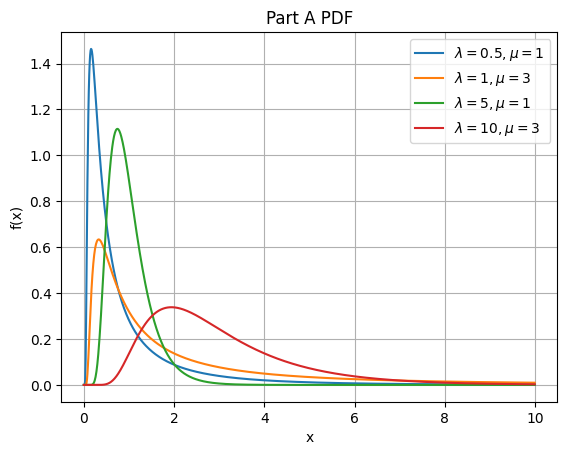

In [6]:
# FUNCTION f ( x | lambda , mu )
def funf(x:float, lmbda:float, mu:float) -> float:
    if (isinstance(x, float) or isinstance(x, int)) and not x > 0:
        return 0
    
    with np.errstate(divide='ignore', invalid='ignore'):
        y = np.where(x > 0, np.sqrt(lmbda / (2 * np.pi * x**3)) * np.exp((-lmbda / (2 * mu**2 * x)) * (x - mu)**2),0)
    return y


delta = 0.01
x = np.arange(0, 10, delta)
z = np.where(x>0,0,1)
#print(z)
for param in PARAMS:
    y = funf(x, **param)
    plt.plot(x, y, label=r'$\lambda={lmbda}, \mu={mu}$'.format(**param))

plt.legend(loc="upper right")
plt.title("Part A PDF")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid()

#plt.savefig("figures/pdf_plot.pdf", format="pdf")
plt.show()

In [7]:
@timeit
def romberg(f: typing.Callable, a: float, b: float, iterations: int, params: typing.Dict[float, float] = {}) -> np.ndarray:
    table = np.zeros((iterations, iterations))

    step = b - a
    table[0, 0] = 0.5 * step * (f(a, **params) + f(b, **params))

    for i in range(1, iterations):
        step *= 0.5
        trapz_values = np.sum(f(a + np.arange(1, 2**i, 2) * step, **params))
        table[i, 0] = 0.5 * table[i-1, 0] + step * trapz_values

        # compute richardson iterations
        for rich_i in range(1, i + 1):
            table[i, rich_i] = table[i, rich_i-1] + (table[i, rich_i-1] - table[i-1, rich_i-1]) / (4**rich_i - 1)
    return table[iterations-1, iterations-1]

@timeit
def riemann(f:typing.Callable, a:float, b:float, delta:float, params:typing.Dict[float, float] = {}) -> float:
    x = np.arange(a, b, delta)
    y = f(x, **params)
    return np.sum(y * delta) 

@timeit
def integratescipy(f:typing.Callable, a:float, b:float, params:typing.Dict[float, float] = {}):
    return quad(f, a, b, (params["lmbda"], params["mu"]))

@timeit
def riemann_slow(f:typing.Callable, a:float, b:float, delta:float, params:typing.Dict[float, float] = {}) -> float:
    sum = 0
    x = a
    while x < b:
        sum += f(x, **params) * delta
        x += delta
    return sum

In [8]:
a = 0
b = 1000

print(romberg(funf, a, b, 25, PARAMS[0]))
print(riemann(funf, a, b, 0.001, PARAMS[0]))
print(riemann_slow(funf, a, b, 0.001, PARAMS[0]))
print(integratescipy(funf, a, b, PARAMS[0]))


romberg took 2.298914699999841s
1.0000000000000004
riemann took 0.1346153000004051s
0.9999999999999998
riemann_slow took 33.306939399999465s
0.9999999999998752
integratescipy took 0.017522600000120292s
(0.9999999999997695, 6.093919971333443e-10)
